In [54]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import Window

import matplotlib.pyplot as plt
import pandas as pd
import unicodedata
import re

# Data Preprocessing notebook

This notebook is used to preprocess the data for the project.

In [55]:
# initialize SparkSession
spark = SparkSession.builder \
    .appName("data03") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .getOrCreate()


# define the data schema
schema = StructType([
    StructField("timestamp", IntegerType(), True),
    StructField("source", StringType(), True),
    StructField("archive", StringType(), True),
    StructField("id", IntegerType(), True),
    StructField("probability", FloatType(), True),
    StructField("keywords", MapType(StringType(), IntegerType()), True),
    StructField("sentiment", FloatType(), True)
])
df = spark.read.format("json").schema(schema).load("data/news/status=success")#.limit(100000).repartition("timestamp") # LIMIT LIMIT LIMIT LIMIT LIMIT

print("There are {} rows in the DataFrame.".format(df.count()))

df.show(truncate=False, n=3)

There are 682905 rows in the DataFrame.
+---------+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- remover duplicados (*manter só primeira linha*)

    - links de noticias duplicados

    - links de noticias com mesmo nome (ou muito parecidos)

    - ~~sets de palavras iguais (ou muito parecidos) que estejam no mesmo mês +-1 mês~~

In [56]:
# remove duplicated archived news
df = df \
        .dropDuplicates(["archive"]) \
        .dropDuplicates(["id"])
print("There are {} rows in the DataFrame.".format(df.count()))

There are 682905 rows in the DataFrame.


In [57]:
# filter out news with very similar names
last_segment = F.split(F.col("archive"), "/").getItem(F.size(F.split(F.col("archive"), "/")) - 1)
before_query = F.split(last_segment, "\\?").getItem(0)
before_underscore = F.split(before_query, "_").getItem(0)

# filter them
final_col = F.when((before_underscore.isNull()) | (before_underscore == ""), F.col("archive")).otherwise(before_underscore)
df = df.withColumn("cleaned_archive", final_col)

# save cleaned archive names
#df.select("archive", "cleaned_archive").write.mode("overwrite").parquet("cleaned_archive")

# remove them
df = df.dropDuplicates(["cleaned_archive"])
print("There are {} rows in the DataFrame.".format(df.count()))

# remove the temporary column
df = df.drop("cleaned_archive")

/opt/anaconda3/envs/InfoMosaic/lib/python3.10/site-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


There are 349519 rows in the DataFrame.


- acertar sentimento das notícias

    - ao invés de fazer "batota no grafo", corrigir distribuição de sentimentos nas noticias

    - ver distribuicao inicial graficamente, tentar aproximar a uma distribuição normal mas sem criar um enviesamento do sentimento real

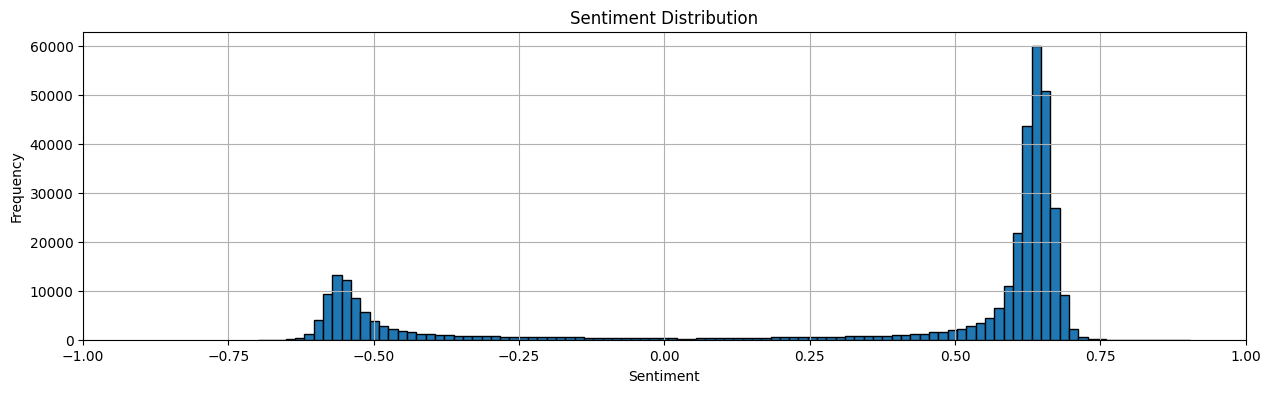

In [58]:
sentiment_pd = df.select("sentiment").toPandas()

plt.figure(figsize=(15, 4))
plt.hist(sentiment_pd["sentiment"], bins=100, edgecolor='black')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-1, 1)
plt.show()

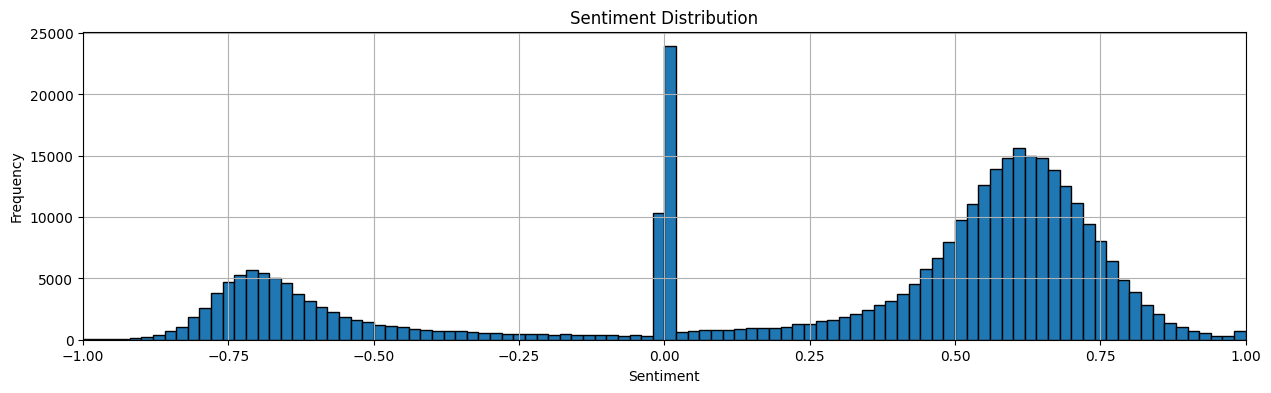

In [59]:
def stretch_sentiment(x, pos_mu, neg_mu):
    if x < 0:
        x2 = neg_mu + 3 * (x - neg_mu)
        return min(-0.01, max(x2, -1))
    else:
        x2 = pos_mu + 5 * (x - pos_mu) - 0.15
        return max(0.01, min(x2, 1))

# mean of the sentiment
sentiment_mean_pos = float(sentiment_pd[sentiment_pd["sentiment"] > 0]["sentiment"].mean())
sentiment_mean_neg = float(sentiment_pd[sentiment_pd["sentiment"] < 0]["sentiment"].mean())

sentiment_pd["new_sentiment"] = sentiment_pd["sentiment"].apply(lambda x: stretch_sentiment(x, sentiment_mean_pos, sentiment_mean_neg))
plt.figure(figsize=(15, 4))
plt.hist(sentiment_pd["new_sentiment"], bins=100, edgecolor='black')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-1, 1)
plt.show()

# apply the new sentiment to the DataFrame
stretch_sentiment_udf = F.udf(lambda x: stretch_sentiment(x, sentiment_mean_pos, sentiment_mean_neg), DoubleType())
df = df.withColumn("sentiment", stretch_sentiment_udf(F.col("sentiment")))

In [60]:
df.show(truncate=False, n=3)

+---------+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- remover tópicos inuteis (ex.: Abr, Abr 2018, ...)

    - ver quantos são ao todo
    
    - se forem poucos, ver um a um

    - se forem muitos, tentar criar modelo ou lista de palavras tipo meses ou assim

    - ver se há tópicos iguais mas diferentes, ex.: Saúde e saúde e se houver, somar tornar todos para minusculo (tlvz fazer lista e ver à mão se fica min ou maisc., mas tlvz a maioria seja minúsculo)

In [61]:
# how many uniques topics
df = df.withColumn("topics", F.map_keys(F.col("keywords")))

# extract unique topics
unique_topics_df = df.select(F.explode("topics").alias("topic")).distinct()

# drop temporary column
df = df.drop("topics")

print(f"Unique topic count: {unique_topics_df.count()}")
#unique_topics_df.coalesce(1).write.mode("overwrite").text("topics.txt")

Unique topic count: 1457234


In [ ]:
# used `dataPrep topicPrep.ipynb` as middle step to preprocess some topics (remove dates, lemmatize, etc.)

In [63]:
topic_map = spark.read.json("topics.json")
topic_map.show(truncate=False, n=10)

+------------------------------------------------------------------------+------------------------------------+
|tokens                                                                  |topic                               |
+------------------------------------------------------------------------+------------------------------------+
|[Mail, Lifestyle]                                                       |Lifestyle   Mail                    |
|[Suécia]                                                                |Suécia                              |
|[Meninas]                                                               |meninas                             |
|[Dependência]                                                           |dependência                         |
|[Giga]                                                                  |giga                                |
|[Covid-19]                                                              |Covid-19 29 Julho             

In [64]:
# Step 1: broadcast the mapping DF
topic_token_map = dict(topic_map.rdd.map(lambda row: (row['topic'], row['tokens'])).collect())
broadcast_map = spark.sparkContext.broadcast(topic_token_map)

# Step 2: UDF to transform keywords
def expand_keywords(keywords: dict) -> dict:
    topic_to_tokens = broadcast_map.value
    new_map = {}

    for topic, count in keywords.items():
        tokens = topic_to_tokens.get(topic)
        if tokens:
            for token in tokens:
                new_map[token] = new_map.get(token, 0) + count
        # If tokens is None or empty, skip it

    return new_map

expand_udf = F.udf(expand_keywords, MapType(StringType(), IntegerType()))

# Step 3: Apply the transformation
df = df.withColumn("keywords", expand_udf("keywords"))

# Step 4: Save the two columns for further analysis
#df1_transformed.select("keywords", "expanded_keywords").write.mode("overwrite").json("expanded_keywords.json")

- pequisa generalizada

    - facilitar pesquisa de topicos, ex.: Banco de Portugal != banco de portugal

    - criar coluna de "topics_in_news" ou assim

        - set de palavras que aparecem na noticia >= 5 vezes

        - palavras minusculas, sem acentos, ...

        - converter por exemplo: Banco de Portugal -> banco de portugal, banco, portugal, ...

    - adaptar pesquisa de tópico da app para usar esta nova coluna

In [65]:
df.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- archive: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- probability: float (nullable = true)
 |-- keywords: map (nullable = true)
 |    |-- key: string
 |    |-- value: integer (valueContainsNull = true)
 |-- sentiment: double (nullable = true)



In [66]:
# new keyword column for significant keywords
df = df.withColumn(
    "significant_keywords",
    F.map_keys(F.map_filter("keywords", lambda k, v: v >= 5))
)

In [67]:
# standardize the significant keywords
def standardize_keywords(texto):
    texto = texto.lower()
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    texto = re.sub(r'[^a-z0-9\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto)
    return texto.strip()

standardize_udf = F.udf(
    lambda arr: [standardize_keywords(x) for x in arr],
    ArrayType(StringType())
)

df = df.withColumn(
    "significant_keywords",
    standardize_udf("significant_keywords")
)

In [68]:
df.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- archive: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- probability: float (nullable = true)
 |-- keywords: map (nullable = true)
 |    |-- key: string
 |    |-- value: integer (valueContainsNull = true)
 |-- sentiment: double (nullable = true)
 |-- significant_keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)



- passar dados para o melhor formato posível

    - parquet vs json

    - multiplos ficheiros pequenos vs alguns médios vs um grande

    - guardar em base de dados

    - adaptar leitura dos dados para o novo formato

In [69]:
df.repartition(8).write.mode("overwrite").parquet("data/news_processed")